In [1]:
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

In [2]:
# turn off scientific notations
np.set_printoptions(suppress=True,precision=4)
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
MODEL_1 = "gemma-2-9b-it"
MODEL_2 = "llama-3.1-8b-it"

df = pd.read_csv(f"analysis/{MODEL_1}_votes.csv")
# df = df.fillna(0.5)
print(df.isna().sum(axis=1))
df = df.fillna(df.mode())
response_cols = [col for col in df.columns if col not in ['category', 'q_id']]
df = df[response_cols]
df = df.T
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
count,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,...,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000,9.0000
mean,0.5556,0.7778,0.4444,0.8889,0.2222,0.4444,1.0000,0.4444,0.7778,0.4444,...,0.4444,0.4444,0.6667,0.7778,0.7778,0.3333,0.2222,0.1111,0.5556,0.3333
std,0.5270,0.4410,0.5270,0.3333,0.4410,0.5270,0.0000,0.5270,0.4410,0.5270,...,0.5270,0.5270,0.5000,0.4410,0.4410,0.5000,0.4410,0.3333,0.5270,0.5000
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
75%,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## Rollcalls Data

In [131]:
# subset to avoid singular matrix and failure in KMO which i think occurs when n_items>>n_candidates
# this doesn't happen in case of general suvey where survey population size is large and questions are few
df = pd.read_csv("irt_files/rollcalls_vote_matrix.csv")#.iloc[:, :102] 
for col in df.columns:
    mode_val = df[col].mode()
    df[col].fillna(mode_val.iloc[0], inplace=True)
    
print(df.isna().sum(axis=1).sum())
print(df.shape)
df.head()

0
(102, 544)


/tmp/ipykernel_456708/1538268142.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val.iloc[0], inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,534,535,536,537,538,539,540,541,542,543
0,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,...,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,...,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## Filter out columns with no variances

In [132]:
zero_var_cols = df.columns[df.std() == 0]
print("Questions with no variance", zero_var_cols.tolist())
df = df.loc[:, df.std() != 0]

Questions with no variance []


In [133]:
#----------------------
# while True:
corr_matrix = df.corr()

print("Null count:", corr_matrix.isnull().sum().sum())
print("INF Count:", np.isinf(corr_matrix).sum().sum())

# Remove problematic rows/columns
corr_matrix = corr_matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')
print("Ill Conditioned (if >1e12)?:", np.linalg.cond(corr_matrix)>1e12)
# if np.linalg.cond(corr_matrix)>1e12:
#     from sklearn.feature_selection import VarianceThreshold

#     # Remove features with variance below threshold
#     selector = VarianceThreshold(threshold=0.01)  # adjust threshold
#     df_filtered = pd.DataFrame(selector.fit_transform(df), 
#                             columns=df.columns[selector.get_support()])

#     # Or manually check variances
#     variances = df.var()
#     low_var_cols = variances[variances < 0.01].index
#     df = df.drop(columns=low_var_cols)
# else:
#     break
#----------------------


# Remove problematic rows/columns
corr_matrix = corr_matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')
rank = np.linalg.matrix_rank(corr_matrix)
expected_rank= corr_matrix.shape[0]
print(f"Matrix rank: {rank}, Meaning {rank} meaningful factors exist, Meaning Factors {rank+1}+ will have eigenvalues of 0.00")
if rank< expected_rank:
    print(f"Since rank:{rank} is < expected rank:{expected_rank}")
    print("""Previous comments on LLM responses (that still holds on new data):
          LLM data has two problems. First, the correlation matrix among the items is not full rank and so the factor analysis is unstable. 
          Second, the factor analysis returns 6 factors with eigenvalue greater than one (which is the normal cutoff). 
          
          My guess is that human data would correct the first problem. But unless the Political Compass questionnaire was designed to measure 
          only one dimension then it's possible that even human responses might return more than one dimension.""")

Null count: 0
INF Count: 0
Ill Conditioned (if >1e12)?: True
Matrix rank: 101, Meaning 101 meaningful factors exist, Meaning Factors 102+ will have eigenvalues of 0.00
Since rank:101 is < expected rank:544
Previous comments on LLM responses (that still holds on new data):
          LLM data has two problems. First, the correlation matrix among the items is not full rank and so the factor analysis is unstable. 
          Second, the factor analysis returns 6 factors with eigenvalue greater than one (which is the normal cutoff). 
          
          My guess is that human data would correct the first problem. But unless the Political Compass questionnaire was designed to measure 
          only one dimension then it's possible that even human responses might return more than one dimension.


## Some Eligibility Tests

### Bartlett Sphericity

Whether to do FA

**Null Hypothesis**: the correlation matrix is an identity matrix

if p_value is < 0.05 (5% significance) we reject it (we do the FA)

In [134]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value, p_value = calculate_bartlett_sphericity(df)
print(chi_square_value, p_value)

-inf 1.0


/home/skabi9001/anaconda3/lib/python3.12/site-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


### KMO Test
Is our sample size enough? We need a kmo_model value > 0.5. 0.8-1.0 means a good sample pool.

In [135]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df)
print(kmo_model)

nan


## Factor Analysis


This code performs a **Principal Factor Analysis (PFA)**, also known as Principal Axis Factoring (PAF), on a dataset. The goal of this analysis is to identify a smaller number of unobserved variables, called **factors**, that can account for the patterns of correlation among a larger set of observed variables.

I perform the analysis in two key stages: first without rotation and then with Varimax rotation.

***



### Unrotated factor analysis using principal axis factoring:

This first block of code extracts the initial factors.

* `FactorAnalyzer(n_factors=6, method='principal', rotation=None)`: I initialize the analysis to extract **6 factors** using the **principal axis factoring** method. `rotation=None` specifies that I want the initial, unrotated solution.
* `get_eigenvalues()`: This calculates the eigenvalues of the *reduced correlation matrix* (where the main diagonal is replaced by initial estimates of communality). Eigenvalues represent the amount of variance accounted for by each factor.
* **Eigenvalue Table**: I create a table to display each factor's eigenvalue, the proportion of total variance it explains, and the cumulative variance.
* `fa_unrotated.loadings_`: This prints the **factor loadings**, which are the correlation coefficients between each original variable and the extracted factors.
* `fa_unrotated.get_uniquenesses()`: This calculates the **uniqueness** for each variable. This is the proportion of a variable's variance that is *not* explained by the common factors. It's calculated as $1 - \text{communality}$. Communality is the proportion of variance that *is* explained by the factors.1

In [136]:
fa_unrotated = FactorAnalyzer(
    n_factors=6,
    method='principal', 
    rotation=None
    ) 
fa_unrotated.fit(df)

FactorAnalyzer(method='principal', n_factors=6, rotation=None,
               rotation_kwargs={})

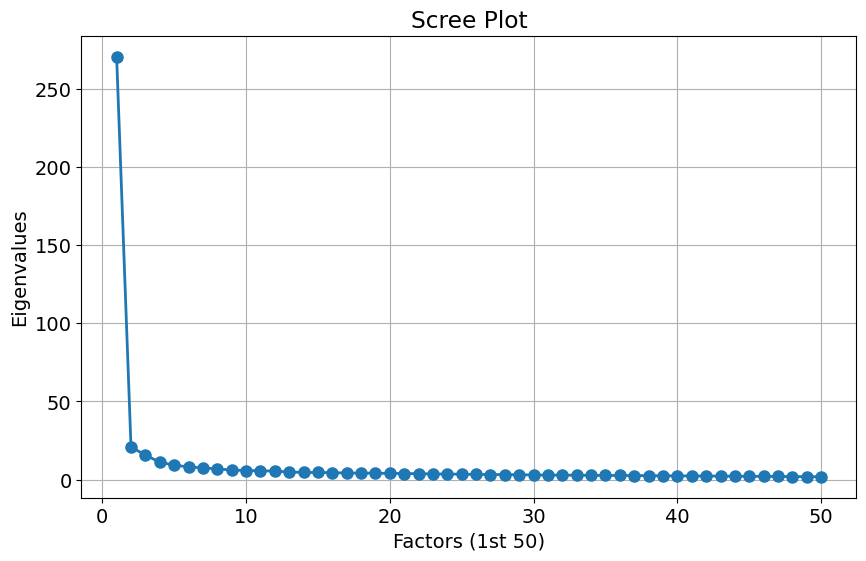

In [147]:
eigenvalues, _ = fa_unrotated.get_eigenvalues()
plt.rcParams.update({'figure.figsize':(10,6), 'font.size': 14})
n_meaningful = 50  # or 8 if you want to be strict
plt.plot(range(1, n_meaningful+1), eigenvalues[:n_meaningful], marker='o', linewidth=2, markersize=8)
plt.title('Scree Plot')
plt.xlabel('Factors (1st 50)')
plt.ylabel('Eigenvalues')
plt.grid()
plt.show()

* **Eigenvalue Table**:
    * We get 8 factors with eigenvalues > 1.0 (which is normally consered as a good cuttof)
    * The first factor is very dominant, with an eigenvalue of **59.60**, explaining **57.3%** of the common variance by itself.
    * The eigenvalues decrease for subsequent factors. The first six factors cumulatively explain about **91.9%** of the variance.

In [145]:
# Calculate the proportion of variance and the cumulative proportion
proportion = eigenvalues / eigenvalues.sum()
cumulative = np.cumsum(proportion)

# Calculate differences between successive eigenvalues
# For the last factor, we set difference to NaN.
difference = np.append(eigenvalues[:-1] - eigenvalues[1:], np.nan)

# Create a DataFrame for a neat display
eigen_table = pd.DataFrame({
    "Factor": [f"Factor{i+1}" for i in range(len(eigenvalues))],
    "Eigenvalue": eigenvalues,
    "Difference": difference,
    "Proportion": proportion,
    "Cumulative": cumulative
})

eigen_table.head(10)#[55:]

,Factor,Eigenvalue,Difference,Proportion,Cumulative
0,Factor1,270.3973,249.5715,0.4971,0.4971
1,Factor2,20.8258,5.0232,0.0383,0.5353
2,Factor3,15.8026,4.6998,0.0290,0.5644
3,Factor4,11.1028,1.6798,0.0204,0.5848
4,Factor5,9.4230,1.3460,0.0173,0.6021
5,Factor6,8.0770,0.4575,0.0148,0.6170
6,Factor7,7.6194,0.7610,0.0140,0.6310
7,Factor8,6.8585,0.6642,0.0126,0.6436
8,Factor9,6.1943,0.3530,0.0114,0.6550
9,Factor10,5.8413,0.0820,0.0107,0.6657


* **Unrotated Factor Loadings**:
    * This matrix is difficult to interpret. For example, the 4th variable has high loadings on both Factor 1 (0.590) and Factor 2 (0.600). This "cross-loading" makes it unclear which factor the variable truly represents. This is the primary reason for performing rotation.

In [126]:
print("Factor loadings (pattern matrix):")
print(fa_unrotated.loadings_)

Factor loadings (pattern matrix):
[[ 0.1282 -0.073   0.043  -0.4308 -0.2821 -0.2418]
 [-0.4748  0.1845 -0.1537  0.2896 -0.0383  0.1506]
 [-0.8518  0.1294  0.0428  0.1202  0.0788 -0.0051]
 [-0.8985  0.132  -0.0793  0.0818 -0.0072 -0.1004]
 [ 0.915  -0.1346  0.0643 -0.0347  0.023   0.0606]
 [ 0.8502 -0.0912  0.0814 -0.0969 -0.0145  0.1636]
 [ 0.8529 -0.077   0.0578 -0.0842 -0.1566  0.1769]
 [-0.6818  0.1418 -0.1171  0.2516  0.1227 -0.0561]
 [-0.8085  0.2248 -0.0034  0.2071 -0.1927  0.1391]
 [ 0.8721 -0.1684  0.0332 -0.0568  0.2083 -0.0864]
 [ 0.923  -0.1863  0.0549  0.0116  0.1318 -0.0343]
 [ 0.9059 -0.1844  0.0879 -0.0064  0.2173 -0.1191]
 [ 0.9142 -0.212   0.0875 -0.0215  0.1897 -0.0334]
 [ 0.9152 -0.2301  0.081  -0.0326  0.1913 -0.0901]
 [ 0.8842 -0.2482  0.0841 -0.0159  0.2217 -0.1116]
 [ 0.6396 -0.1214  0.1119 -0.0236 -0.2363 -0.034 ]
 [ 0.6562 -0.22    0.1107 -0.0345  0.2003 -0.2045]
 [ 0.8777 -0.2071  0.124   0.0132  0.2465 -0.126 ]
 [ 0.9025 -0.1695  0.0883  0.0512  0.2428 -0.069

* **Uniquenesses**:
    * These values show how much of each variable's variance is unique to that variable and not captured by the 6 factors. For instance, the first variable has a uniqueness of **0.23481**. This means its communality is $1 - 0.23481 = 0.76519$, so about 76.5% of its variance is shared with other variables through the common factors.

In [127]:
# Unique variances:
print("Uniquenesses:")
print(fa_unrotated.get_uniquenesses())

Uniquenesses:
[0.6528 0.609  0.2351 0.1522 0.1351 0.2258 0.2004 0.4199 0.1964 0.1559
 0.0917 0.0763 0.0741 0.0571 0.0877 0.5062 0.4256 0.0945 0.0826 0.1208
 0.1551 0.1194 0.2176 0.4481 0.1453 0.2306 0.0449 0.0472 0.0683 0.149
 0.0496 0.1596 0.1103 0.1067 0.1112 0.3096 0.0903 0.4002 0.282  0.2107
 0.0292 0.1517 0.1221 0.0362 0.169  0.2089 0.0913 0.4972 0.0609 0.2884
 0.1056 0.0976 0.1078 0.1851 0.0661 0.1605 0.2093 0.0958 0.2433 0.3175
 0.0814 0.0491 0.0292 0.0292 0.409  0.6881 0.2241 0.0668 0.0617 0.0531
 0.0292 0.2551 0.2503 0.0861 0.2128 0.167  0.3767 0.4873 0.0491 0.0491
 0.3088 0.4249 0.3719 0.4697 0.4651 0.6375 0.3401 0.6261 0.1414 0.5889
 0.6358 0.4967 0.4006 0.5521 0.9232 0.2993 0.679  0.8763 0.3791 0.1215
 0.2526 0.3614]


### Factor analysis with varimax rotation:

The initial solution is often difficult to interpret because variables can load moderately on multiple factors. The second block of code rotates the factors to achieve a **simple structure**, which makes interpretation easier.

* `FactorAnalyzer(..., rotation='varimax')`: I run the analysis again, but this time I apply a **Varimax rotation**. Varimax is an *orthogonal* rotation method that simplifies the factor structure by maximizing the variance of the squared loadings for each factor. This pushes loadings to be either very high (close to 1) or very low (close to 0).
* **Rotated Variance Table**: After rotation, the total variance explained is redistributed among the factors. This table shows the **Sum of Squared Loadings (SSL)** for each *rotated* factor. While the initial factors are ordered by how much variance they explain, this order can change after rotation.
* `fa_rotated.loadings_`: This prints the **rotated factor loadings**. These should be much easier to interpret, as each variable will ideally have a high loading on only one factor.
* `fa_rotated.rotation_matrix_`: This shows the transformation matrix that was used to rotate the factor axes from their original position to their final, rotated position.


In [128]:
fa_rotated = FactorAnalyzer(
    n_factors=6, 
    method='principal', 
    rotation='varimax'
    )
fa_rotated.fit(df)

FactorAnalyzer(method='principal', n_factors=6, rotation='varimax',
               rotation_kwargs={})

* **Factor Rotation Matrix**:
    * This 6x6 matrix shows how the original factor axes were mathematically rotated. For example, the new Factor 1 is `0.730 * (Old Factor 1) - 0.259 * (Old Factor 2) - ...` and so on. This is generally for technical verification and not used for interpretation.

In [129]:
print("Factor Rotation Matrix")
print("-----------------------")
rotation_matrix = fa_rotated.rotation_matrix_

# Create a DataFrame for a nicer display and add row and column labels:
rotation_df = pd.DataFrame(
    rotation_matrix,
    columns=[f"Factor{i+1}" for i in range(rotation_matrix.shape[1])],
    index=[f"Factor{i+1}" for i in range(rotation_matrix.shape[0])]
)
rotation_df

Factor Rotation Matrix
-----------------------


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
Factor1,0.8779,0.1648,-0.0629,0.1350,-0.0330,0.4230
Factor2,-0.4167,0.4691,0.1534,-0.1166,0.0893,0.7491
Factor3,0.1112,-0.4906,0.7856,-0.1564,0.2879,0.1496
Factor4,-0.0444,0.3818,0.4000,0.7869,0.1273,-0.2383
Factor5,-0.1142,-0.3930,-0.4419,0.3800,0.6544,0.2542
Factor6,-0.1682,-0.4603,0.0054,0.4244,-0.6809,0.3408


* **Rotated Factor Variance Table**:
    * The total explained variance is **redistributed**. Notice that the variance for Factor 1 is now **36.67** (down from 59.60), while the variance for Factor 3 is **23.52** (up from 11.04).
    * The total variance explained by all 6 factors remains the same, but the rotation has spread it out more evenly to create a more interpretable solution. The order has also changed: Factor 3 now explains more variance than Factor 2.

In [130]:
# Extract the rotated factor loadings (pattern matrix)
loadings = fa_rotated.loadings_

# Compute the variance explained by each rotated factor
# (sum of squared loadings for each factor)
variance = np.sum(loadings**2, axis=0)

# Calculate the differences between consecutive variances
# For the last factor, we set the difference to NaN (as in Stata output)
difference = np.append(variance[:-1] - variance[1:], np.nan)

# Compute the proportion of variance and the cumulative proportion
proportion = variance / variance.sum()
cumulative = np.cumsum(proportion)

# Create a table (DataFrame) similar to the Stata output
rotated_table = pd.DataFrame({
    "Factor": [f"Factor{i+1}" for i in range(len(variance))],
    "Variance": np.round(variance, 5),
    "Difference": np.round(difference, 5),
    "Proportion": np.round(proportion, 4),
    "Cumulative": np.round(cumulative, 4)
})

rotated_table

,Factor,Variance,Difference,Proportion,Cumulative
0,Factor1,50.6506,46.4909,0.6604,0.6604
1,Factor2,4.1597,1.6555,0.0542,0.7147
2,Factor3,2.5042,-0.6284,0.0327,0.7473
3,Factor4,3.1326,1.2114,0.0408,0.7881
4,Factor5,1.9212,-12.4055,0.0250,0.8132
5,Factor6,14.3267,NaN,0.1868,1.0000


* **Rotated Factor Loadings (The Most Important Output) ✨**:
    * This matrix demonstrates a **simple structure**.
    * **Example**: Look at the 4th variable again. It now has a very high loading on **Factor 2 (0.914)** and very low loadings on all other factors. Similarly, the 8th variable loads strongly on **Factor 3 (0.815)** and weakly on the rest.
    * This clarity allows I to interpret the factors. I would examine all the variables that load highly on Factor 2 to understand what underlying concept or construct it represents.

In [73]:
print("Rotated factor loadings (pattern matrix):")
print(fa_rotated.loadings_)

Rotated factor loadings (pattern matrix):
[[ 0.0988  0.0202 -0.0693  0.2003 -0.1158 -0.0082]
 [-0.3834 -0.1374  0.0492 -0.2883  0.4257  0.051 ]
 [-0.7803 -0.1155 -0.057  -0.309   0.2836 -0.0165]
 ...
 [ 0.1531  0.5375  0.103   0.2351  0.1182  0.0668]
 [-0.0271  0.4922  0.0093  0.2305  0.1991 -0.0211]
 [ 0.1818  0.5136 -0.049   0.0713  0.2123  0.028 ]]


* **Uniquenesses (Rotated)**:
    * This output is **identical** to the uniquenesses from the unrotated analysis. Rotation only changes the orientation of the factors; it **does not** change the amount of total variance explained for each variable (communality) or the variance left unexplained (uniqueness).

In [130]:
# Unique variances:
print("Uniquenesses:")
print(fa_rotated.get_uniquenesses())

Uniquenesses:
[0.0421 0.0003 0.0034 0.0083 0.0099 0.0034 0.0034 0.0154 0.0205 0.2676
 0.0034 0.0034 0.1182 0.0249 0.0034 0.0421 0.1033 0.0003 0.014  0.0003
 0.0022 0.0095 0.0034 0.0022 0.0022 0.0034 0.0154 0.0421 0.0154 0.1084
 0.0009 0.0212 0.0034 0.0083 0.0083 0.0003 0.0003 0.0034 0.0022 0.2676
 0.0034 0.0022 0.0003 0.0034 0.0814 0.1182 0.0034 0.0037 0.0034 0.0377
 0.0421 0.0034 0.0003 0.0083 0.0003 0.1424 0.0034 0.0083 0.0034 0.0083
 0.0009 0.0003 0.0099 0.0034 0.0022 0.0073 0.0003 0.0034 0.0022 0.0034
 0.0083 0.0003 0.2676 0.0003 0.0034 0.0814 0.1769 0.0022 0.0022 0.1722
 0.0814 0.0083 0.0034 0.0022 0.0022 0.0154 0.0034 0.0022 0.0034 0.0078
 0.0034 0.0034 0.0083 0.1722 0.2676 0.0022 0.0003 0.1769 0.0022 0.0003
 0.0127 0.0421 0.0022]


* **Analysing the Questiuons:** 
    * I will now analyze all the questions with high loadings > 0.5 (focusing on questions which had the high loading on Factor-2)

In [74]:
import json
pd.set_option('display.max_colwidth', None)
loadings_df = pd.DataFrame(fa_rotated.loadings_)
print(loadings_df)
questions_df = pd.DataFrame([x['statement'] for x in json.load(open("data_for_STA/data/politically-liberal/test_new.json", "r"))],
                            columns=['statement'])
print("\nDropped questions:", questions_df.iloc[zero_var_cols])
questions_df = questions_df.drop(zero_var_cols).reset_index(drop=True)

merged_df = questions_df.join(loadings_df)
# selected_rows = (merged_df[list(range(6))] > 0.5).any(axis=1)
# let's filter by one factor at a time
selected_rows = (merged_df[[1]] > 0.5).any(axis=1)
# print("\nRejected rows:", merged_df[~selected_rows])
filtered_df = merged_df[selected_rows]
# filtered_df.to_csv("analysis/questions_w_high_loadings.csv", index=False)
print("Num of ques with high loading", len(filtered_df))

filtered_df

          0       1       2       3       4       5
0    0.0988  0.0202 -0.0693  0.2003 -0.1158 -0.0082
1   -0.3834 -0.1374  0.0492 -0.2883  0.4257  0.0510
2   -0.7803 -0.1155 -0.0570 -0.3090  0.2836 -0.0165
3   -0.8343 -0.1429 -0.0637 -0.1633  0.2078 -0.0327
4    0.8590  0.1397  0.0624  0.1560 -0.1706  0.0439
..      ...     ...     ...     ...     ...     ...
539  0.1336 -0.0586  0.0386  0.1469 -0.0339 -0.1240
540  0.1988  0.0721  0.1102  0.1325 -0.0780 -0.1707
541  0.1531  0.5375  0.1030  0.2351  0.1182  0.0668
542 -0.0271  0.4922  0.0093  0.2305  0.1991 -0.0211
543  0.1818  0.5136 -0.0490  0.0713  0.2123  0.0280

[544 rows x 6 columns]

Dropped questions: Empty DataFrame
Columns: [statement]
Index: []
Num of ques with high loading 3


,statement,0,1,2,3,4,5
59,Refugees from foreign countries present a danger to society and should be kept out,0.2408,0.5731,-0.0592,-0.0451,-0.1503,0.2237
64,I don't care about the financial plight of middle class Americans and the poor,0.3910,0.5145,-0.0952,-0.0082,-0.0413,0.2519
101,"I believe that we should cut social welfare programs like Social Security, Medicare and Medicaid to reduce government spending",0.3547,0.6276,0.0460,-0.0284,0.0137,0.2704


### Summary

In short, my code successfully extracted 6 underlying factors from my data. The initial **unrotated solution** showed how much variance each factor captured but was difficult to interpret. The **Varimax rotation** simplified the factor loadings, revealing a clear pattern where each variable is strongly associated with just one factor, which is the primary goal for interpreting and naming the underlying constructs.